In [1]:
import numpy as np
import os
import pandas as pd

from bestiapop import bestiapop

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Working with lists of lat/lon combinations

In this example we will download climate data based off a list of lat/lon datapoints

### Define your climate extraction variables

We need to define the scope of what type of data and output we expect from BestiaPop.

> **NOTE**: the `coordinate_list` variable contains lists of lat/lon pairs where the first value is `latitutde` and the second value is `longitude`

## Example: getting climate data for the entire potato production areas of Tasmania, Australia 

In this example we retrieved 1724 grids of 5 km resolution from SILO. This lat/lon combinations were masked for the entire potato production areas in Tasmania, Australia. Then we put it in a dataframe and work with the data to create statistical summary and maps of each climate variable.

In [ ]:
# Define variables to pass in to Bestiapop

#You need to host your lat/lon list in some web server like GitHub and then provide the url. This example is using a csv hosted in our GitHub repo (sample-data)
from csv import reader
url = "https://raw.githubusercontent.com/JJguri/bestiapop/master/sample-data/bpop_tassie_example.csv" #specify url
csv_reader = reader(url)
coordinate_list = [list(row) for row in df.values]
coordinate_list
action='generate-climate-file' #specify action
data_source='silo' #specify dta source
year_range='2015-2016' #specify range of years
climate_variables=['radiation', 'max_temp', 'min_temp', 'daily_rain'] #specify climate variables
output_type='dataframe'
output_path=None

## Instantiate and run BestiaPop

In this instance we will iterate over the lat/lon combinations

In [ ]:
final_df = pd.DataFrame()

for coord in coordinate_list:
    print('Fetching data for {}/{}'.format(coord[0], coord[1]))
    climate_data = bestiapop.CLIMATEBEAST(
        action='generate-climate-file',
        data_source=data_source,
        output_path=output_path,
        output_type=output_type,
        input_path=None,
        climate_variables=climate_variables,
        year_range=year_range,
        lat_range=[coord[0]],
        lon_range=[coord[1]],
        multiprocessing=None
        )
    data = climate_data.process_records(action)
    final_df = final_df.append(data, ignore_index=True)

# Show the final dataframe
final_df

## Calculating yearly statistics

Let's calculate some statistics base on the climate data we retrieved from SILO

> NOTE: here we presente the sum of rain and radiation and the mean of daily minimum and maximum temperature across years. You can change the parameters you want to get lookin at the [GroupBy](https://pandas.pydata.org/pandas-docs/stable/reference/groupby.html) documentation.

In [48]:
#calculate yearly mean of mint and maxt (degree C) and cummulative radn (MJ m-2) and rain (mm) during across years and lat/lon combinations
mini = final_df.groupby(['lon','lat','year'], as_index=True)['maxt'].mean().round(decimals=1)
maxi = final_df.groupby(['lon','lat','year'], as_index=True)['mint'].mean().round(decimals=1)
radn = final_df.groupby(['lon','lat','year'], as_index=True)['radn'].sum().round(decimals=1)
rain = final_df.groupby(['lon','lat','year'], as_index=True)['rain'].sum().round(decimals=1)
st0 = pd.merge(radn, mini, on=(['lon','lat','year']), how='outer')
st00 = pd.merge(maxi, rain, on=(['lon','lat','year']), how='outer')
st_final = pd.merge(st0, st00, on=(['lon','lat','year']), how='outer')
st_final

#Save the statistical summary in the current dir
#st_final.to_csv(os.getcwd())

radn  maxt  mint    rain
lon    lat    year                            
143.85 -40.05 2015  4634.7  16.7  10.0   746.4
              2016  4382.6  16.9  10.7  1114.1
143.90 -40.10 2015  4637.1  16.4   9.9   787.8
              2016  4383.6  16.7  10.6  1153.6
       -39.90 2015  4641.3  16.7   9.8   687.4
...                    ...   ...   ...     ...
148.40 -40.35 2016  5102.2  18.1  11.9   985.7
148.45 -40.45 2015  5333.9  17.6  11.2   589.5
              2016  5104.8  18.0  11.8   967.7
       -40.40 2015  5336.2  17.7  11.2   588.0
              2016  5105.7  18.1  11.9   961.0

[3444 rows x 4 columns]

## This code re-structure the datasets before mapping

In [50]:
#Preparinf dataset to plot
radnrain = final_df.groupby(['lat', 'lon','year'],as_index=True).sum()
temp = final_df.groupby(['lat', 'lon','year'],as_index=True).mean()
#Reseting index
Pre_nc = radnrain.reset_index()
#Set indexes
Pre_nc.set_index(['lat', 'lon', 'year'], inplace=True)
df2 = Pre_nc[~Pre_nc.index.duplicated(keep='first')]
#From 2D dataframe to xarray
nc_r = df2.to_xarray()
#Reseting index
Pre_nc = temp.reset_index()
#Set indexes
Pre_nc.set_index(['lat', 'lon', 'year'], inplace=True)
df2 = Pre_nc[~Pre_nc.index.duplicated(keep='first')]
#From 2D dataframe to xarray
nc_t = df2.to_xarray()

## Mapping rainfall

> NOTE: Each 5 km grid represents the mean (across years) of cumulative rainfall during the year

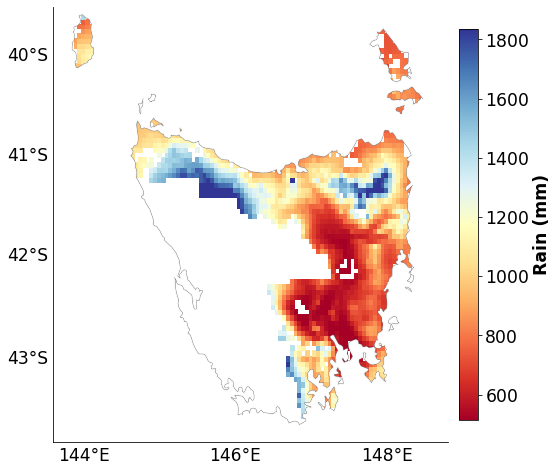

In [55]:
#Packages required for the mapping functions
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#Plotting single map with cumulative rain during the year <--update central longitude in 'projection=ccrs.Mercator(' accordingly with the region of interest
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=146)),figsize=(10,8))
p=nc_r.rain.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, zorder=1, add_colorbar=False)

#Arranguing features, borders and axis labels 
gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "grey", linewidth=0.3, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)

#you will need to update the 3 following lines accordingly with the region of interest
ax.set_extent([143.6, 148.8, -43.8, -39.5], crs=ccrs.PlateCarree())
gl.xlocator = mticker.FixedLocator([144, 146, 148])
gl.ylocator = mticker.FixedLocator([-40, -41, -42,-43])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 17, 'color': 'k'}
gl.ylabel_style = {'size': 17, 'color': 'k'}
ax.outline_patch.set_visible(False)
ax.spines['left'].set_visible(True)  
ax.spines['bottom'].set_visible(True)

#Setting colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rain (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

#Save the map to the current directory
#plt.savefig(os.getcwd(), dpi=600, bbox_inches='tight', pad_inches=0)

## Mapping solar radiation

> NOTE: Each 5 km grid represents the mean (across years) of cumulative solar dariation during the year

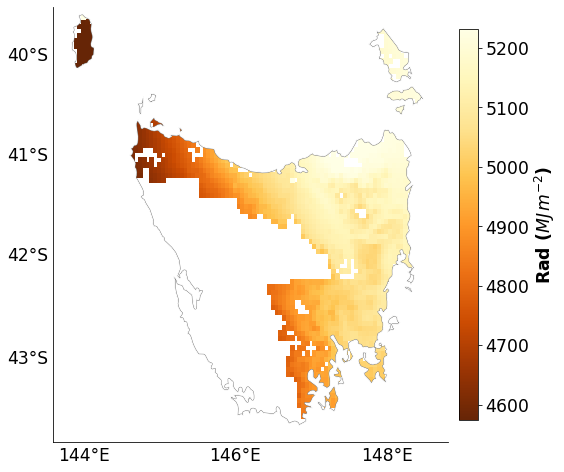

In [58]:
#Packages required for the mapping functions
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#Plotting single map with cumulative rain during the year <--update central longitude in 'projection=ccrs.Mercator(' accordingly with the region of interest
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=146)),figsize=(10,8))
p=nc_r.radn.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.YlOrBr_r, zorder=1, add_colorbar=False)

#Arranguing features, borders and axis labels 
gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "grey", linewidth=0.3, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)

#you will need to update the 3 following lines accordingly with the region of interest
ax.set_extent([143.6, 148.8, -43.8, -39.5], crs=ccrs.PlateCarree())
gl.xlocator = mticker.FixedLocator([144, 146, 148])
gl.ylocator = mticker.FixedLocator([-40, -41, -42,-43])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 17, 'color': 'k'}
gl.ylabel_style = {'size': 17, 'color': 'k'}
ax.outline_patch.set_visible(False)
ax.spines['left'].set_visible(True)  
ax.spines['bottom'].set_visible(True)

#Setting colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rad ($MJ\,m^{-2}$)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

#Save the map to the current directory
#plt.savefig(os.getcwd(), dpi=600, bbox_inches='tight', pad_inches=0)

## Mapping minimum temperature

> NOTE: Each 5 km grid represents the mean (across years) of the mean minimum temperature during the year

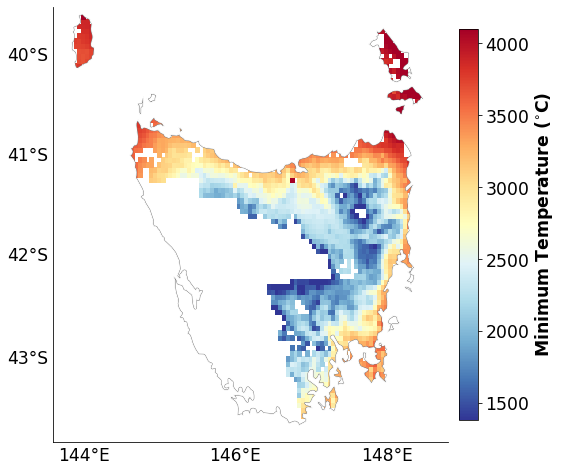

In [59]:
#Packages required for the mapping functions
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#Plotting single map with cumulative rain during the year <--update central longitude in 'projection=ccrs.Mercator(' accordingly with the region of interest
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=146)),figsize=(10,8))
p=nc_r.mint.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu_r, zorder=1, add_colorbar=False)

#Arranguing features, borders and axis labels 
gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "grey", linewidth=0.3, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)

#you will need to update the 3 following lines accordingly with the region of interest
ax.set_extent([143.6, 148.8, -43.8, -39.5], crs=ccrs.PlateCarree())
gl.xlocator = mticker.FixedLocator([144, 146, 148])
gl.ylocator = mticker.FixedLocator([-40, -41, -42,-43])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 17, 'color': 'k'}
gl.ylabel_style = {'size': 17, 'color': 'k'}
ax.outline_patch.set_visible(False)
ax.spines['left'].set_visible(True)  
ax.spines['bottom'].set_visible(True)

#Setting colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Minimum Temperature ($^{\circ}$C)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

#Save the map to the current directory
#plt.savefig(os.getcwd(), dpi=600, bbox_inches='tight', pad_inches=0)

## Mapping minimum temperature

> NOTE: Each 5 km grid represents the mean (across years) of the mean maximum temperature during the year

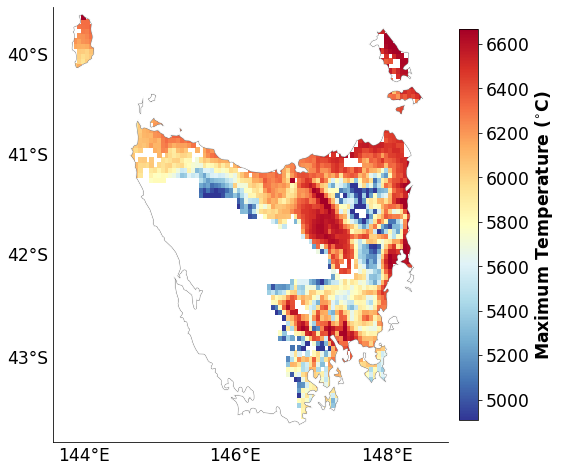

In [60]:
#Packages required for the mapping functions
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

#Plotting single map with cumulative rain during the year <--update central longitude in 'projection=ccrs.Mercator(' accordingly with the region of interest
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=146)),figsize=(10,8))
p=nc_r.maxt.mean(dim=('year'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu_r, zorder=1, add_colorbar=False)

#Arranguing features, borders and axis labels 
gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=2)
ax.add_feature(cfeature.STATES, edgecolor = "grey", linewidth=0.3, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)

#you will need to update the 3 following lines accordingly with the region of interest
ax.set_extent([143.6, 148.8, -43.8, -39.5], crs=ccrs.PlateCarree())
gl.xlocator = mticker.FixedLocator([144, 146, 148])
gl.ylocator = mticker.FixedLocator([-40, -41, -42,-43])
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 17, 'color': 'k'}
gl.ylabel_style = {'size': 17, 'color': 'k'}
ax.outline_patch.set_visible(False)
ax.spines['left'].set_visible(True)  
ax.spines['bottom'].set_visible(True)

#Setting colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Maximum Temperature ($^{\circ}$C)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

#Save the map to the current directory
#plt.savefig(os.getcwd(), dpi=600, bbox_inches='tight', pad_inches=0)

## Zip the generated MET files ans maps & Download them

Let's now grab all the MET files and maps and compress them. We need to get rid of the ocasional minus sign at the beginning of some 
MET files (depending on your lat/lon range), because `tar` does not do well with such filenames. In any case, this code should work for you.

> NOTE: make sure to change the extension of the file, depending on which format you chose for the output.

In [ ]:
%%bash
for f in *.met; do
    mv -- "$f" "bpop.${f}"
done

tar chvfz bestiapop_files.tar.gz bpop*

Search for your file by clicking `file --> open` in the top left menu of this JupterNotebook. You can download the compressed file and unzip in your own machine (we recommend you use `7zip` if using a Windows machine).

![image-2.png](attachment:files.png)